In [2]:
# !pip install -U pip wheel
# !pip install -q -r /Users/ryan/github/lltk/requirements.txt
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'/Users/ryan/github/prosodic')
sys.path.insert(0,'/Users/ryan/github/lltk')
from llmdh import *
from prosodic import Word
prosodic.USE_CACHE=False
import plotnine as p9
from sqlitedict import SqliteDict
p9.options.figure_size=11,8
import lltk

In [3]:
def get_rhyme_data(dbfn='sqlitedict_poems.db', force=False, min_lines=8):
    path_db=os.path.join(PATH_DATA,dbfn)
    db=SqliteDict(path_db, autocommit=True)    
    o=[]
    keys=list(db.keys())
    random.shuffle(keys)
    for key in tqdm(keys):
        data = db[key]
        if force or not 'num_rhyming_lines' in data:
            with prosodic.logmap.verbosity(0):
                txt=data['poem'] if 'poem' in data else data['Content']
                if not txt: continue
                poem = prosodic.Text(txt)
                llist = prosodic.LineList(
                    l
                    for st in poem.stanzas
                    for l in st.lines
                    if len(st.lines)>1
                    and len(l.wordtokens)>1
                )[:100]
                data['num_lines'] = len(llist)
                if data['num_lines']:
                    rhymes=llist.get_rhyming_lines(max_dist=1)
                    rhymeset = set(rhymes.keys()) | set(v[1] for v in rhymes.values())
                    data['num_rhyming_lines'] = len(rhymeset)
                    data['perc_rhyming_lines'] = data['num_rhyming_lines'] / data['num_lines'] * 100
                else:
                    data['num_rhyming_lines'] = np.nan
                    data['perc_rhyming_lines'] = np.nan
                db[key] = data
        if data['num_lines']>=min_lines:
            o.append(data)
    return pd.DataFrame(o).dropna()

In [4]:
fn='data.chadwyck_rhyme.pkl'
df5=pd.read_pickle(fn)

def catyear(y,ybin=50):
    y=(y-30)//ybin*ybin
    return f'b. {y}-{y+ybin}'

df5['model']=df5['year'].apply(catyear)
df5['prompt_type']='Human'
latest_median = df5[df5.model=='b. 1950-2000'].perc_rhyming_lines.median()

In [5]:
df1=get_rhyme_data('sqlitedict_poems.db', force=False).assign(prompt_type='do_NOT_rhyme')
df2=get_rhyme_data('sqlitedict_poems_rhyme.db', force=False).assign(prompt_type='DO_rhyme')
df3=get_rhyme_data('sqlitedict_poems_mayberhyme.db', force=False).assign(prompt_type='MAYBE_rhyme')
df=pd.concat([df1,df2,df3,df5])
df.to_pickle('data.allpoems.pkl')

100%|██████████| 2561/2561 [00:00<00:00, 11044.32it/s]


In [6]:
excl_prompts=[
    # 'Write an unryhmed poem in the style of Shakespeare\'s dramatic monologues.',
    'Write a poem in the style of e.e. cummings',
    # 'Write a poem in the style of Walt Whitman.',
    'Write a poem in the style of Wallace Stevens.',
    'Continue the following poem:\n\nTyping, typing, fingers on the keyboard\nThe keys crack and bend under sweat and weight,\n'
]
figdf=df[~df.prompt.isin(excl_prompts)]
figdf['fline']=figdf['poem'].apply(lambda x: x.strip().split('\n')[0])
figdf=figdf.drop_duplicates('fline')

model_rename={'Chadwyck': 'Human',
 'claude-3-haiku-20240307': 'Claude (Anthropic)',
 'claude-3-opus-20240229': 'Claude (Anthropic)',
 'claude-3-sonnet-20240229': 'Claude (Anthropic)',
 'gemini-pro': 'Gemini (Google)',
 'gpt-3.5-turbo': 'GPT (OpenAI)',
 'gpt-4-turbo': 'GPT (OpenAI)',
 'llama2-uncensored:7b': 'Llama (open source)'}
figdf['model']=figdf.model.apply(lambda x: model_rename.get(x,x))

for k in ['model','prompt']:
    figdf[k] = pd.Categorical(
        figdf[k], 
        categories=figdf.groupby(k).perc_rhyming_lines.median().sort_values(ascending=True).index,
    )

prompt_type_rename = {
    'MAYBE_rhyme':'LLM: "Write a poem"', 
    'DO_rhyme':'LLM: "Write a rhyming poem"', 
    'do_NOT_rhyme':'LLM: "Write an unrhyming poem"', 
    'Human':'Human: Poetic history'
}

figdf['prompt_type']=pd.Categorical(figdf['prompt_type'], categories=['Human','MAYBE_rhyme','DO_rhyme','do_NOT_rhyme'])
figdf['prompt_type']=figdf.prompt_type.apply(lambda x: prompt_type_rename.get(x,x))
figdf.prompt_type.value_counts()
figdf.to_pickle('data.figdf.allpoems.pkl')

In [7]:
figdf['perc_rhyming_lines_bin'] = figdf['perc_rhyming_lines'].apply(lambda x: int(round(x,0)))
figdf2=pd.concat(
    gdf.iloc[:1].assign(poem_count=len(gdf))
    for g,gdf in figdf.groupby(['prompt_type','model','perc_rhyming_lines_bin'])
)
# figdf2
# figdf.model.value_counts()

In [14]:
figdf[~figdf.prompt_type.str.contains('Human')].perc_rhyming_lines.median()


16.666666666666664

In [20]:
figdf[figdf.prompt_type.str.contains('Human')].groupby('model').perc_rhyming_lines.median().dropna()


model
b. 1950-2000    11.111111
b. 1900-1950    14.285714
b. 1850-1900    23.809524
b. 1750-1800    25.000000
b. 1800-1850    25.714286
b. 1700-1750    29.166667
b. 1650-1700    34.285714
b. 1600-1650    40.000000
Name: perc_rhyming_lines, dtype: float64

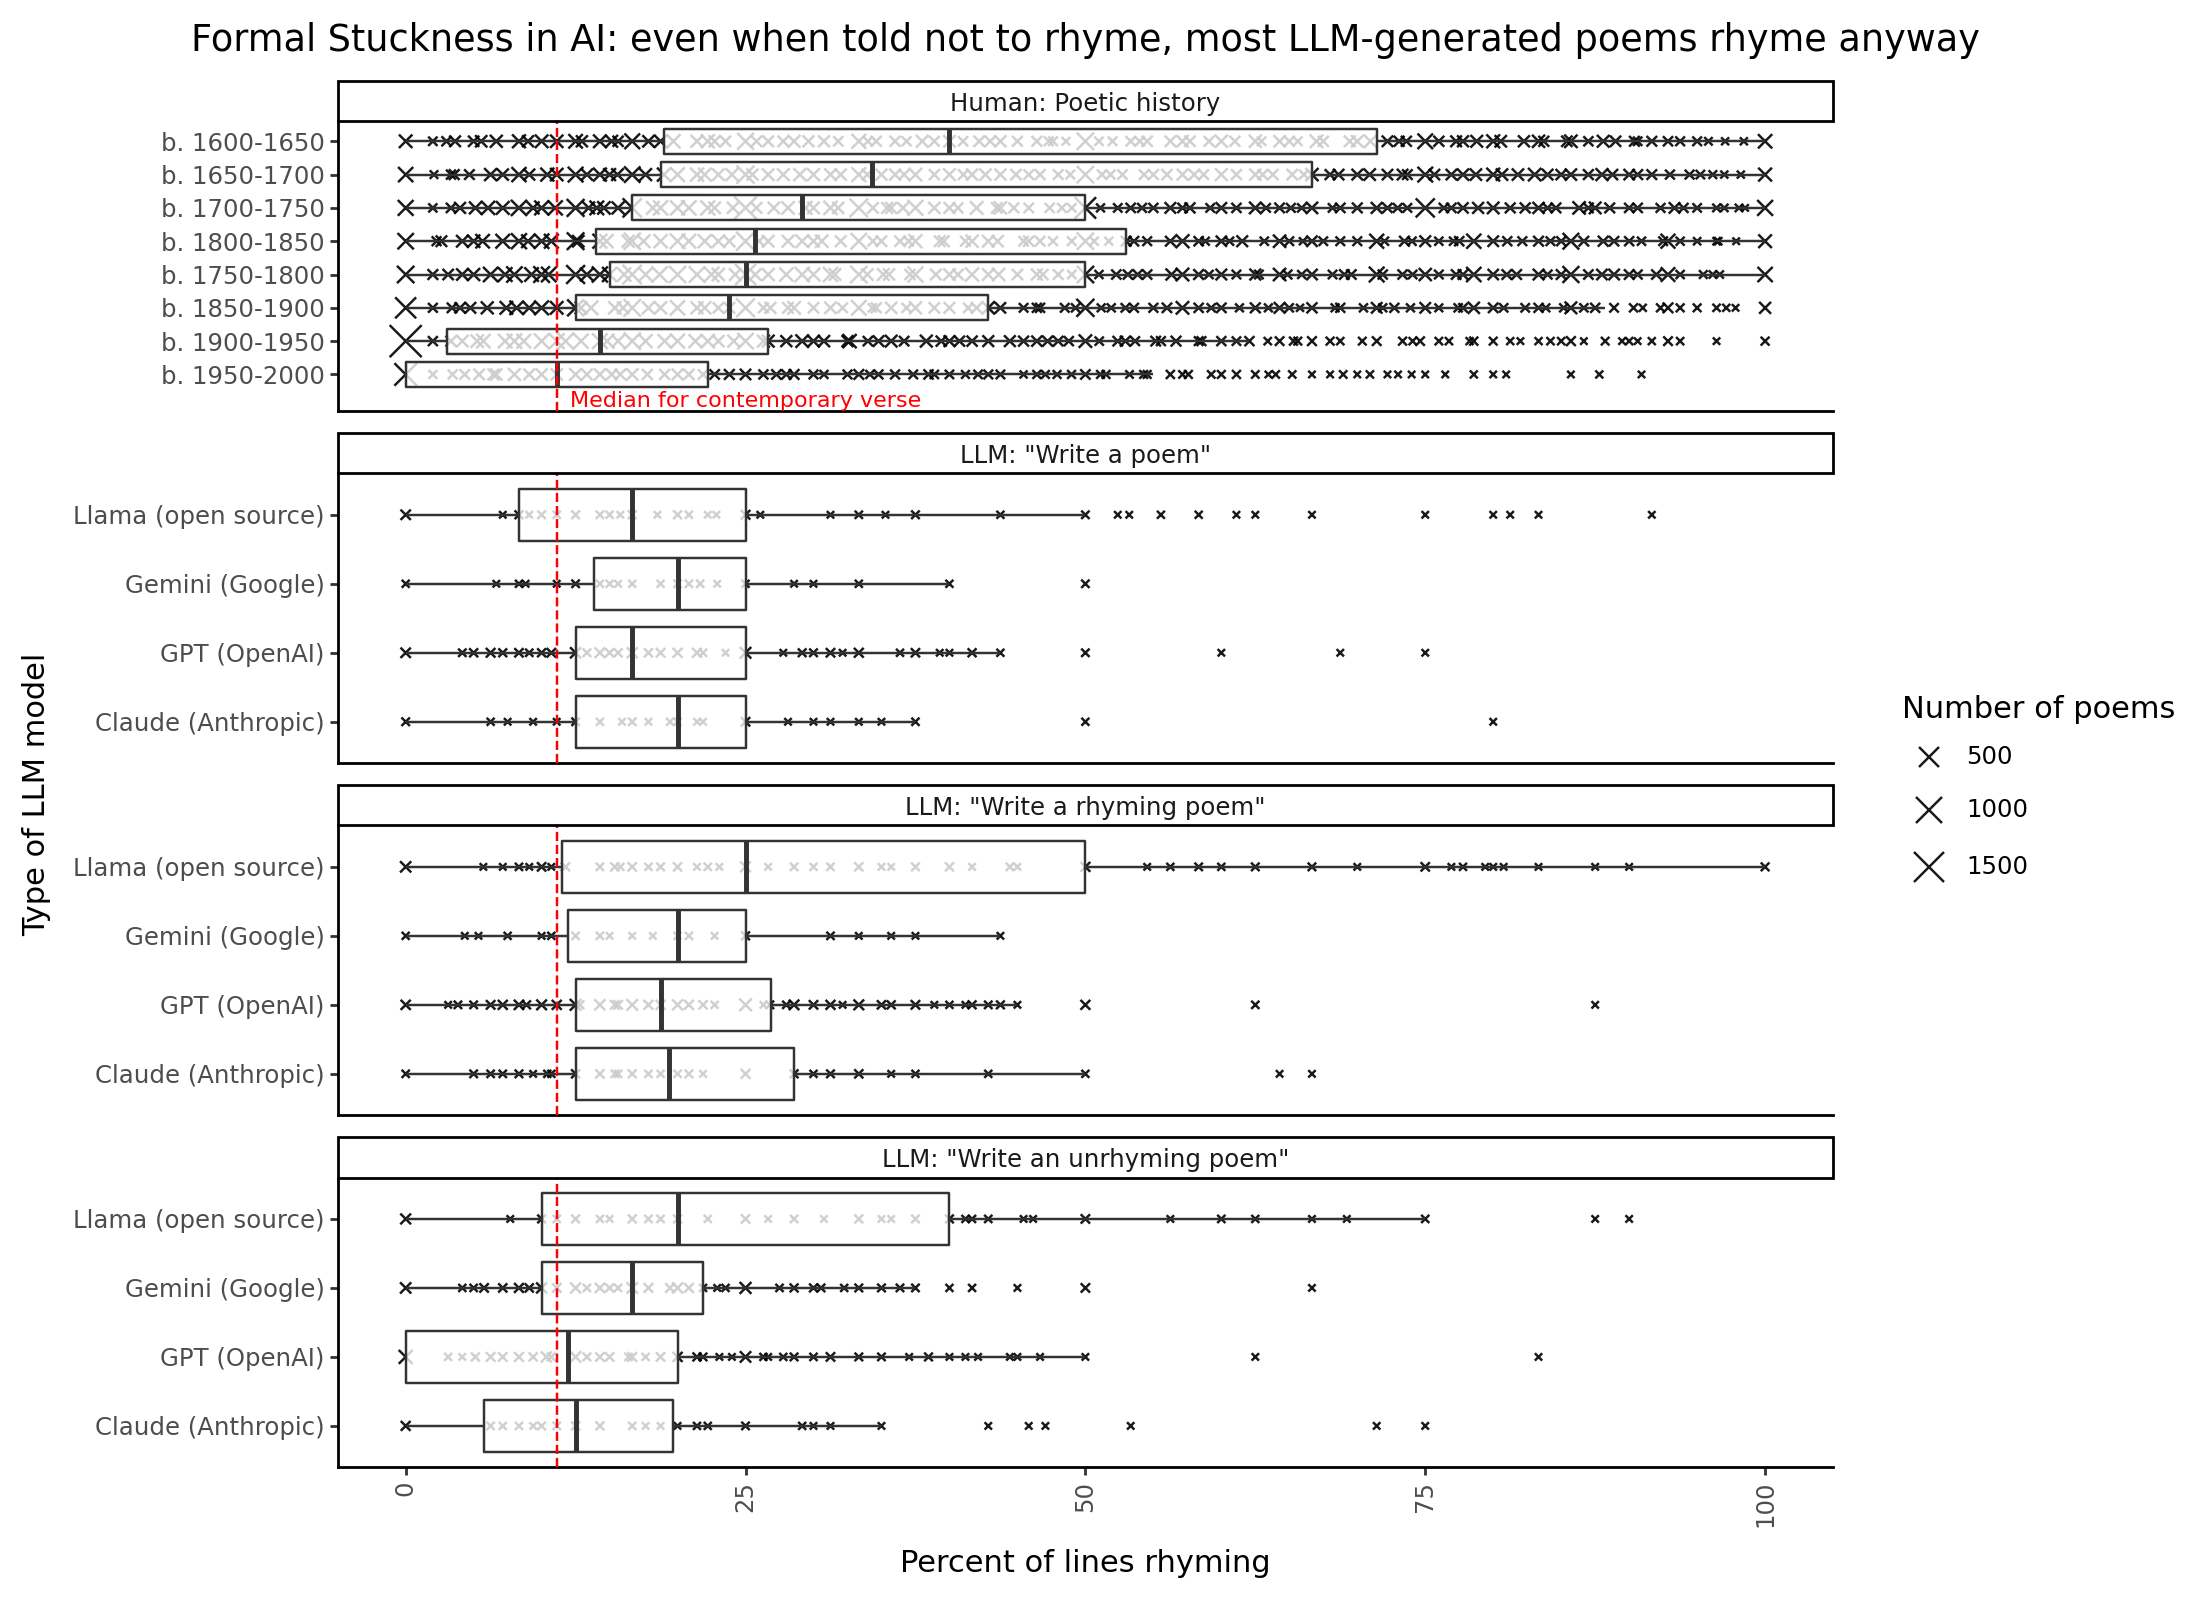

In [10]:
fig=p9.ggplot(figdf, p9.aes(x='model', y='perc_rhyming_lines'))
fig+=p9.theme_classic()
fig+=p9.theme(axis_text_x=p9.element_text(angle=90))
fig+=p9.geom_point(p9.aes(size='poem_count'), shape='x', data=figdf2, alpha=.9)
fig+=p9.geom_boxplot(alpha=.8, outlier_shape='')
fig+=p9.facet_wrap('prompt_type', nrow=9, scales='free_y')
fig+=p9.labs(
    title="Formal Stuckness in AI: even when told not to rhyme, most LLM-generated poems rhyme anyway",
    y='Percent of lines rhyming',
    x='Type of LLM model',
    size='Number of poems',
    caption=''
)
# overall_median = figdf['perc_rhyming_lines'].median()

# Add a horizontal line for the overall median
fig += p9.geom_hline(yintercept=latest_median, linetype='dashed', color='red')
# Calculate medians for each subgroup defined by 'prompt_type'
medians = figdf.groupby('prompt_type')['perc_rhyming_lines'].median().reset_index()
medians_df = pd.DataFrame({
    'prompt_type': medians['prompt_type'],
    'median': medians['perc_rhyming_lines']
})
# fig += p9.geom_hline(p9.aes(yintercept='median'), data=medians_df, linetype='dashed', color='blue')
# Add label for the median line
# fig += p9.annotate('text', label='Latest Median: {:.1f}%'.format(latest_median),
#                    x=0.5,  # Choose an appropriate x position
#                    y=0,     # Choose an appropriate y position (after coord_flip this is the bottom)
#                    ha='center', size=10, color='red')
# anndata = pd.DataFrame([
#     {'perc_rhyming_lines':latest_median,
#      'model':'b. 1950-2000',
#      'prompt_type':'Human: Poetic history'
#     }
# ])
anndata = figdf[(figdf.model == 'b. 1950-2000') & (figdf.prompt_type.str.contains('Human'))].sample(frac=1)
anndata['perc_rhyming_lines'] = anndata['perc_rhyming_lines'].median()
anndata=anndata.iloc[:1]

fig+=p9.geom_text(data=anndata, label='Median for contemporary verse', ha='left', va='bottom', size=8, color='red', nudge_y=1, nudge_x=-1.1)

fig+=p9.coord_flip()
fig.save('fig.rhyme_box_plots.v4.png')
fig

In [12]:
anndata['perc_rhyming_lines']

61137    11.111111
Name: perc_rhyming_lines, dtype: float64

In [172]:
# fig=p9.ggplot(figdf, p9.aes(x='prompt_type', y='perc_rhyming_lines'))
# fig+=p9.theme_classic()
# fig+=p9.theme(axis_text_x=p9.element_text(angle=90))
# # fig+=p9.geom_violin(alpha=.75)
# fig+=p9.geom_point(p9.aes(size='poem_count'), shape='x', data=figdf2, alpha=.9)
# fig+=p9.geom_boxplot(p9.aes(color='prompt_type'), alpha=.8, outlier_shape='')
# # fig+=p9.geom_smooth()
# # fig+=p9.facet_grid('model~prompt')
# # fig+=p9.facet_wrap('model', ncol=7)
# # fig+=p9.facet_wrap('prompt_type', ncol=3)
# # fig+=p9.facet_wrap('prompt_type', ncol=3)
# # fig+=p9.facet_grid('model~prompt_type')
# # figdf['prompt_type']=pd.Categorical()
# fig+=p9.labs(
#     title="Formal Stuckness in AI: even when told not to rhyme, most LLM-generated poems rhyme anyway",
#     y='Percent of lines rhyming',
#     x='LLM temperature parameter',
#     size='Number of lines',
#     # caption='Prompts used, in order of least to most rhymes:\n- '+'\n- '.join(figdf.prompt.unique())
# )
# fig+=p9.coord_flip()
# # fig.save('fig.rhyme_box_plots.3way.png')
# fig

In [ ]:

fig=p9.ggplot(figdf, p9.aes(x='prompt', y='perc_rhyming_lines', size='num_lines'))
fig+=p9.theme_classic()
fig+=p9.geom_boxplot(p9.aes(color='model'), alpha=.5, outlier_shape='')
fig+=p9.geom_boxplot(alpha=.25, outlier_shape='')
# fig+=p9.geom_point(shape='x')
# fig+=p9.facet_grid('model~prompt')
# fig+=p9.facet_wrap('model')
fig+=p9.coord_flip()
fig+=p9.labs(
    title='Formal Stuckness: varying the prompt to produce unrhymed verse produces no significant effect on rhyming',
    x='Percent of lines rhyming',
    y='Prompt to LLM',
    color='LLM model'
)
fig